In [1]:

import findspark
from functools import reduce
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import plotly as py
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

In [3]:
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

In [4]:
df_matches = load_dataframe(r'C:\Users\PC\Downloads\Wrangling_PySpark-main\Wrangling_PySpark-main\Data\Matches.csv')
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



In [5]:
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [6]:
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]

In [7]:
old_new_cols = [*zip(old_cols, new_cols)]

In [8]:
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col, new_col)

In [9]:
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|            2|            1|          H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|            1|            3|          A|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+



In [10]:
df_matches = df_matches.withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
                        .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
                        .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))

In [11]:
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+-----------+-----------+-------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+-----------+-----------+-------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|            2|            1|          H|          1|          0|      0|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|            0|            1|          A|          0|          1|      0|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|            1|            1|          D|          0|          0|      1|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|            2|            1|          H|          1|          0|      0|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe| 

In [12]:
bundesliga = df_matches.filter((col('Season') >= 2000) & (col('Season') <= 2010) & (col('Div') == 'D1'))

In [13]:
bundesliga.count()

3366

In [14]:
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

In [15]:
home.limit(5).toPandas()

,Season,Team,TotalHomeWin,TotalHomeLoss,TotalHomeTie,HomeScoredGoals,HomeAgainstGoals
0,2005,Kaiserslautern,5,7,5,26.0,33.0
1,2006,Cottbus,6,6,5,21.0,22.0
2,2001,St Pauli,4,9,4,19.0,28.0
3,2005,Mainz,6,4,7,31.0,23.0
4,2006,Hamburg,4,4,9,22.0,19.0


In [16]:
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

In [17]:
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window)) 

table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Bayern Munich,2000,62.0,37.0,25.0,19,9,6,55.88,1
1,Leverkusen,2001,77.0,38.0,39.0,21,7,6,61.76,1
2,Bayern Munich,2002,70.0,25.0,45.0,23,5,6,67.65,1
3,Werder Bremen,2003,79.0,38.0,41.0,22,4,8,64.71,1
4,Bayern Munich,2004,75.0,33.0,42.0,24,5,5,70.59,1
5,Bayern Munich,2005,67.0,32.0,35.0,22,3,9,64.71,1
6,Stuttgart,2006,61.0,37.0,24.0,21,6,7,61.76,1
7,Bayern Munich,2007,68.0,21.0,47.0,22,2,10,64.71,1
8,Wolfsburg,2008,80.0,41.0,39.0,21,7,6,61.76,1
9,Bayern Munich,2009,72.0,31.0,41.0,20,4,10,58.82,1


In [18]:
table.groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('WinPct').alias('AvgWinPct'),
                          avg('GoalDifferentials').alias('AvgGD'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
.orderBy(desc("TotalChampionships")).toPandas().round(1)

,Team,TotalChampionships,AvgWinPct,AvgGD,AvgWin,AvgLoss,AvgTie
0,Schalke 04,11,48.1,14.3,16.4,9.2,8.5
1,Werder Bremen,11,50.3,20.7,17.1,9.7,7.2
2,Leverkusen,11,47.3,17.8,16.1,10.0,7.9
3,Hamburg,11,41.2,5.2,14.0,10.9,9.1
4,Wolfsburg,11,37.4,3.2,12.7,13.0,8.3
5,Stuttgart,11,44.4,9.6,15.1,10.1,8.8
6,Bayern Munich,11,60.7,35.5,20.6,5.8,7.5
7,Dortmund,11,45.5,14.2,15.5,8.8,9.7
8,Hertha,10,40.0,2.8,13.6,12.1,8.3
9,Hannover,9,34.0,-9.0,11.6,13.9,8.6


In [19]:
oktoberfest = df_matches.filter(col('Div') == 'D1') \
                .filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date'))) \
                .groupby('Month') \
                .agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals')).alias('Goals'),
                     sum('GameTie').alias('GameTie'),
                     count(col('FinalResult')).alias('Total')) \
                .withColumn('Goals_to_games_ratio', round(col('Goals')/col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', round(col('GameTie')/col('Total'), 1))

In [20]:
oktoberfest_df = oktoberfest.toPandas()

In [21]:
oktoberfest_df = oktoberfest_df.sort_values('Month')
oktoberfest_df

,Month,Goals,GameTie,Total,Goals_to_games_ratio,GameTie_to_games_ratio
1,1,386.0,27,140,2.8,0.2
10,2,1108.0,110,415,2.7,0.3
2,3,1076.0,96,386,2.8,0.2
5,4,1138.0,90,416,2.7,0.2
3,5,993.0,65,308,3.2,0.2
7,7,14.0,2,8,1.8,0.3
6,8,871.0,82,298,2.9,0.3
4,9,1027.0,91,364,2.8,0.3
8,10,1036.0,81,354,2.9,0.2
9,11,1160.0,92,387,3.0,0.2


In [22]:
import calendar
oktoberfest_df['Month'] = [calendar.month_name[val] for val in oktoberfest_df.Month.tolist()]

In [23]:
oktoberfest_df.set_index('Month', drop=True, inplace=True)

In [24]:
oktoberfest_df

,Goals,GameTie,Total,Goals_to_games_ratio,GameTie_to_games_ratio
Month,,,,,
January,386.0,27,140,2.8,0.2
February,1108.0,110,415,2.7,0.3
March,1076.0,96,386,2.8,0.2
April,1138.0,90,416,2.7,0.2
May,993.0,65,308,3.2,0.2
July,14.0,2,8,1.8,0.3
August,871.0,82,298,2.9,0.3
September,1027.0,91,364,2.8,0.3
October,1036.0,81,354,2.9,0.2


<AxesSubplot:xlabel='Month'>

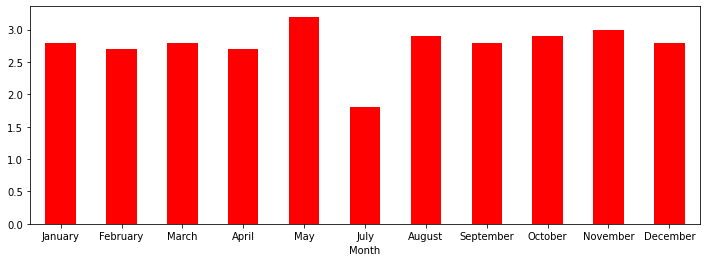

In [25]:
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))


In [28]:
pwd

'C:\\Users\\PC'